In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


# 1L model

In [2]:
torch.cuda.set_device(2)
device = 'cuda:2'
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/SimpleModel"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.03, use_simple_model=True, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="/data/tianyu/birth/data", device=device)

In [3]:
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


(array([ 4.,  3.,  2.,  0.,  0.,  0.,  2., 18., 24., 14.]),
 array([-1.54632819, -0.06263319,  1.42106175,  2.90475678,  4.38845158,
         5.87214661,  7.35584164,  8.83953667, 10.3232317 , 11.80692673,
        13.29062176]),
 <BarContainer object of 10 artists>)

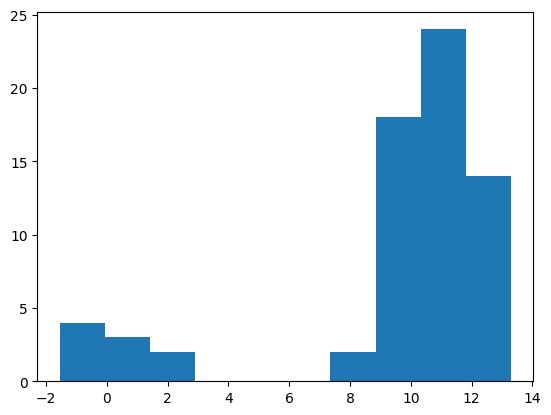

In [7]:
plt.hist(model.layers[0].attention.qk_bos.cpu().detach())

In [15]:
model.layers[0].attention.wo(model.layers[0].attention.wv_bos).norm()

tensor(0.2970, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>)

In [17]:
model_loader.change_steps(0)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
model.layers[0].attention.wo(model.layers[0].attention.wv_bos).norm()

tensor(4.1159, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>)

(array([ 2.,  0.,  1.,  0.,  0.,  0.,  1.,  5., 23., 35.]),
 array([-16.27219009, -14.47073174, -12.66927338, -10.86781502,
         -9.06635571,  -7.26489735,  -5.46343899,  -3.66198039,
         -1.86052203,  -0.05906347,   1.74239504]),
 <BarContainer object of 10 artists>)

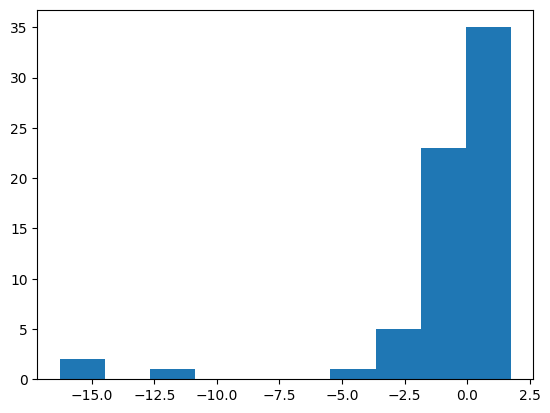

In [13]:
plt.hist(model.layers[0].attention.wv_bos.cpu().detach().numpy())

In [6]:
model.layers[1].attention.qk_direction

Parameter containing:
tensor([ 0.0084,  0.0186, -0.0173,  0.0150, -0.0117, -0.0150,  0.0057,  0.0106,
        -0.0083, -0.0081,  0.0194, -0.0142, -0.0076,  0.0112, -0.0095,  0.0306,
         0.0021,  0.0303, -0.0166, -0.0016,  0.0039,  0.0154,  0.0137, -0.0053,
         0.0045, -0.0228, -0.0164, -0.0259, -0.0004,  0.0128, -0.0193,  0.0129,
         0.0225, -0.0278,  0.0270, -0.0172, -0.0121,  0.0006,  0.0112, -0.0164,
        -0.0032, -0.0012,  0.0127,  0.0138,  0.0148, -0.0179,  0.0088,  0.0194,
        -0.0032,  0.0036, -0.0114,  0.0404,  0.0180,  0.0210, -0.0026,  0.0420,
        -0.0245, -0.0116, -0.0090, -0.0119,  0.0103,  0.0250,  0.0051, -0.0027,
         0.0299, -0.0360,  0.0035], device='cuda:2')

In [18]:
outputs_norms = {}
logits = {}
value_states_norm = {}
minimal_layer_idx = 0
copy_layer_idx = 1 if cfg.simple_model_args.n_layers==3 else 0
with torch.no_grad():
    for step in tqdm(torch.arange(0, 1000, 5).tolist()+torch.arange(1000, 10001, 200).tolist()):
        model_loader.change_steps(step)
        model, cfg, optim = model_loader(with_data=False)
        _, outputs_list = model.modified_forward(x, triggers_pos)
        outputs_norms[step] = outputs_list[minimal_layer_idx]['output'][0, 0, :].norm(dim=-1).item()
        logits[step] = outputs_list[copy_layer_idx]['attn_logits'][0, 1, 0].item()
        value_states_norm[step] = outputs_list[copy_layer_idx]['value_states'][0, 0, :].norm().item()


100%|██████████| 246/246 [00:22<00:00, 11.03it/s]


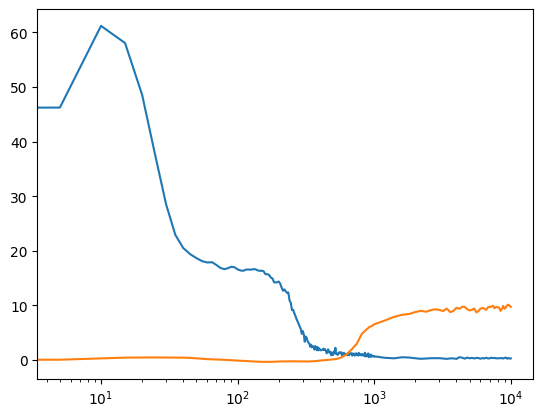

In [21]:
plt.plot(list(value_states_norm.keys()), list(value_states_norm.values()))
plt.plot(list(logits.keys()), list(logits.values()))
plt.gca().set_xscale('log')

# 1L Model SGD

In [28]:
torch.cuda.set_device(2)
device = 'cuda:2'
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/SimpleModel_sgd"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.3, use_simple_model=True, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="/data/tianyu/birth/data", device=device)

In [32]:
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))

In [33]:
outputs_norms = {}
logits = {}
value_states_norm = {}
minimal_layer_idx = 0
copy_layer_idx = 1 if cfg.simple_model_args.n_layers==3 else 0
with torch.no_grad():
    for step in tqdm(torch.arange(0, 1000, 5).tolist()+torch.arange(1000, 10001, 200).tolist()):
        model_loader.change_steps(step)
        model, cfg, optim = model_loader(with_data=False, with_optim=False)
        _, outputs_list = model.modified_forward(x, triggers_pos)
        outputs_norms[step] = outputs_list[minimal_layer_idx]['output'][0, 0, :].norm(dim=-1).item()
        logits[step] = outputs_list[copy_layer_idx]['attn_logits'][0, 1, 0].item()
        value_states_norm[step] = outputs_list[copy_layer_idx]['value_states'][0, 0, :].norm().item()


  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:18<00:00, 13.38it/s]


In [35]:
pred, outputs_list = model.modified_forward(x, triggers_pos)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(0.1254, device='cuda:2', grad_fn=<MeanBackward0>),
 tensor(2.2461, device='cuda:2', grad_fn=<MeanBackward0>))

In [37]:
model.layers[0].attention.qk_bos

Parameter containing:
tensor([ 1.8750e+00,  1.5426e-01,  3.9361e+00, -7.3682e-02, -1.9843e-02,
         4.3839e+00,  6.3839e+00,  8.8357e-01,  3.7789e+00,  4.6113e+00,
         4.3199e+00,  4.8335e+00,  3.2150e+00,  3.2030e+00,  2.6910e+00,
         1.9264e-02,  3.6383e+00,  2.5005e+00,  2.5654e+00,  3.7445e+00,
         3.6252e+00,  5.3368e+00,  4.6447e-02,  3.1328e-01,  2.1371e+00,
         1.2273e+00,  2.6032e+00,  2.3207e+00,  1.5135e+00,  1.3031e-02,
         1.6678e+00,  3.9442e+00,  8.5427e-01, -4.7150e-03,  2.1362e-01,
         3.1029e+00, -2.2600e-02,  3.7243e+00,  8.5364e-02,  5.0878e+00,
         3.9934e+00,  4.7701e+00,  6.5368e+00,  1.9001e-02,  5.6888e+00,
         5.5652e+00,  6.3680e+00,  4.9763e+00,  5.3753e-01,  5.5731e+00,
         5.8315e+00,  5.5487e+00,  6.2585e+00,  5.5696e+00,  4.7976e+00,
        -1.7536e-02,  6.4829e+00,  6.5351e+00,  7.3235e-02,  5.9345e+00,
         5.7021e+00,  4.8961e+00,  1.5261e+00,  6.0899e+00,  3.8882e+00,
         4.4024e-02,  3.6404e

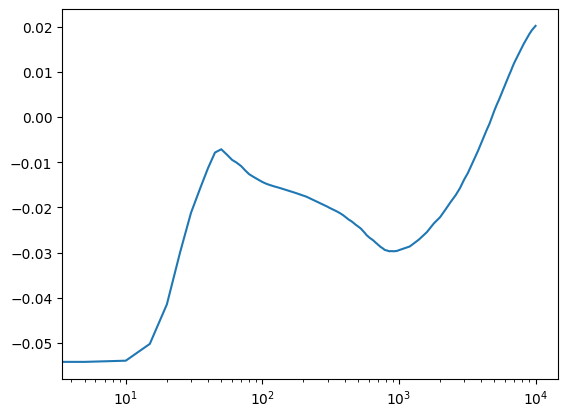

In [36]:
# plt.plot(list(value_states_norm.keys()), list(value_states_norm.values()))
plt.plot(list(logits.keys()), list(logits.values()))
plt.gca().set_xscale('log')

# 3L model SGD

In [22]:
torch.cuda.set_device(2)
device = 'cuda:2'
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/SimpleModel_sgd"
no_attn = (2, )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.03, use_simple_model=True, use_vo=True, use_read_out=True, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="/data/tianyu/birth/data", device=device)

In [23]:
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))

In [24]:
outputs_norms = {}
logits = {}
value_states_norm = {}
minimal_layer_idx = 0
copy_layer_idx = 1 if cfg.simple_model_args.n_layers==3 else 0
with torch.no_grad():
    for step in tqdm(torch.arange(0, 1000, 5).tolist()+torch.arange(1000, 10001, 200).tolist()):
        model_loader.change_steps(step)
        model, cfg, optim = model_loader(with_data=False, with_optim=False)
        _, outputs_list = model.modified_forward(x, triggers_pos)
        outputs_norms[step] = outputs_list[minimal_layer_idx]['output'][0, 0, :].norm(dim=-1).item()
        logits[step] = outputs_list[copy_layer_idx]['attn_logits'][0, 1, 0].item()
        value_states_norm[step] = outputs_list[copy_layer_idx]['value_states'][0, 0, :].norm().item()


100%|██████████| 246/246 [00:24<00:00, 10.10it/s]


In [26]:
pred, outputs_list = model.modified_forward(x, triggers_pos)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(0.3070, device='cuda:2', grad_fn=<MeanBackward0>),
 tensor(2.2717, device='cuda:2', grad_fn=<MeanBackward0>))

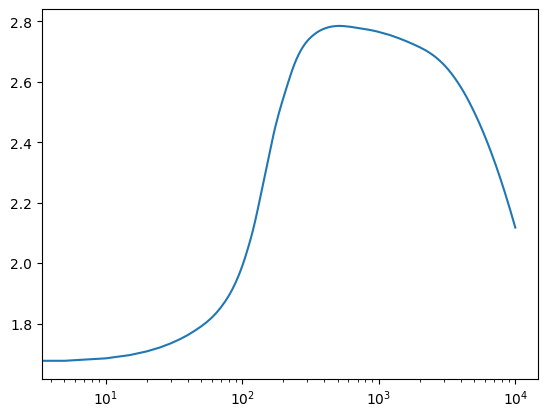

In [27]:
# plt.plot(list(value_states_norm.keys()), list(value_states_norm.values()))
plt.plot(list(logits.keys()), list(logits.values()))
plt.gca().set_xscale('log')

# 3L model

In [ ]:
torch.cuda.set_device(2)
device = 'cuda:2'
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/SimpleModel"
no_attn = (2, )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.03, use_simple_model=True, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="/data/tianyu/birth/data", device=device)

In [8]:
outputs_list[0]['attn_output_bos'].norm(), outputs_list[0]['mlp_output_bos'].norm(), outputs_list[0]['output'][0, 0, :].norm()

(tensor(256.7952, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>),
 tensor(307.3895, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>),
 tensor(517.9832, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>))

In [9]:
outputs_list[1]['value_states'][0, 0, :].norm()

tensor(0.3559, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>)

In [10]:
outputs_list[1]['attn_input'][0, 0, :].norm()

tensor(39.0045, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>)

In [24]:
outputs_list[1]['attn_input'][0, 0, :] @ model.layers[1].attention.qk_direction

tensor(-5.2264, device='cuda:2', grad_fn=<DotBackward0>)

In [25]:
outputs_list[1]['attn_logits'][0, :, 0]

tensor([231.3096,   8.6937,   0.0000,   8.0742, -13.0311,   9.8954, -11.4225,
          0.0000, -11.4225,   8.6598,   0.0000,   8.6598,   9.6224,  11.2676,
          8.1976,   0.0000,   8.1976, -13.0311, -13.0311,  10.5327,  10.9918,
          0.0000,  10.9918,   0.0000,  10.9918,  12.1920,  11.1069,  10.8083,
         11.2676,  10.7640,  12.2951,   0.0000,  12.2951,   0.0000,  12.2951,
         10.8084,  10.9918,   0.0000,  10.9918,  11.6126,   0.0000,  11.6126,
          0.0000,  11.6126,  11.5330,   0.0000,  11.5330,   3.7355, -13.0311,
          9.8954, -11.4225,   0.0000, -11.4225,   0.0000, -11.4225,   8.6900,
         10.4241,   9.9627,   9.0958,   8.3665,   8.6005,  12.1920,  11.1069,
          8.0742, -13.0311, -13.0311,  11.0284,   7.8226,  10.4241,  10.9434,
          8.6900,  10.4241,   9.9627,  10.0263,   8.6005,   3.7355,   0.0000,
          3.7355,   0.0000,   3.7355, -13.0311, -11.4225,   0.0000, -11.4225,
          0.0000, -11.4225,   8.6005,   0.0000,   8.6005,  10.41

In [11]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

layers.0.pre_attn_norm.weight
layers.0.pre_attn_norm.bias
layers.0.wv.weight
layers.0.wo.weight
layers.0.pre_mlp_norm.weight
layers.0.pre_mlp_norm.bias
layers.0.mlp.w1.weight
layers.0.mlp.w2.weight
layers.1.pre_attn_norm.weight
layers.1.pre_attn_norm.bias
layers.1.pre_mlp_norm.weight
layers.1.pre_mlp_norm.bias
layers.1.attention.wv_bos
layers.1.attention.wv
layers.1.attention.qk_bos
layers.1.attention.qk_previous
layers.1.attention.wo.weight
layers.1.ff.w1.weight
layers.1.ff.w2.weight
layers.2.pre_attn_norm.weight
layers.2.pre_attn_norm.bias
layers.2.pre_mlp_norm.weight
layers.2.pre_mlp_norm.bias
layers.2.mlp.w1.weight
layers.2.mlp.w2.weight
norm.weight
norm.bias
read_out.weight


In [12]:
outputs_norms = {}
logits = {}
value_states_norm = {}
minimal_layer_idx = 0
copy_layer_idx = 1 if cfg.simple_model_args.n_layers==3 else 0
with torch.no_grad():
    for step in tqdm(torch.arange(0, 1000, 5).tolist()+torch.arange(1000, 10001, 200).tolist()):
        model_loader.change_steps(step)
        model, cfg, optim = model_loader(with_data=False)
        _, outputs_list = model.modified_forward(x, triggers_pos)
        outputs_norms[step] = outputs_list[minimal_layer_idx]['output'][0, 0, :].norm(dim=-1).item()
        logits[step] = outputs_list[copy_layer_idx]['attn_logits'][0, 1, 0].item()
        value_states_norm[step] = outputs_list[copy_layer_idx]['value_states'][0, 0, :].norm().item()


  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:18<00:00, 13.16it/s]


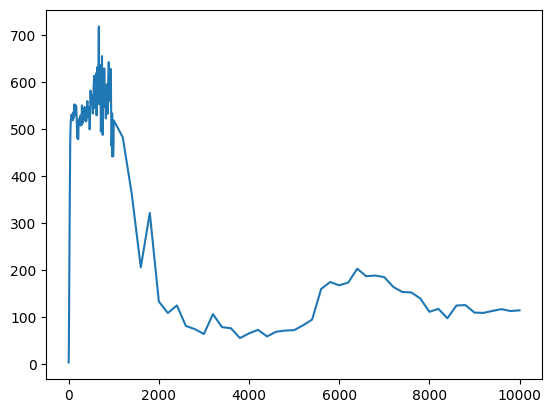

In [13]:
plt.plot(outputs_norms.keys(), outputs_norms.values(), label='output_0')

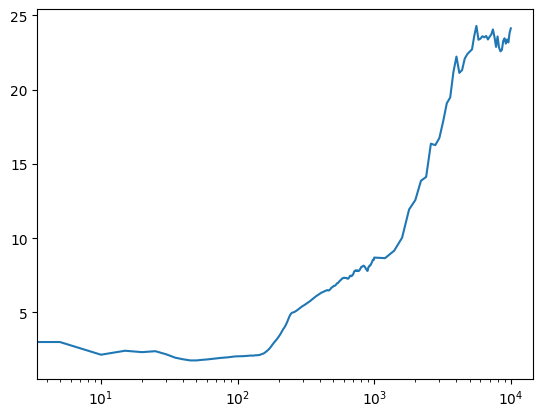

In [14]:
plt.plot(logits.keys(), logits.values(), label='logits')
plt.gca().set_xscale('log')

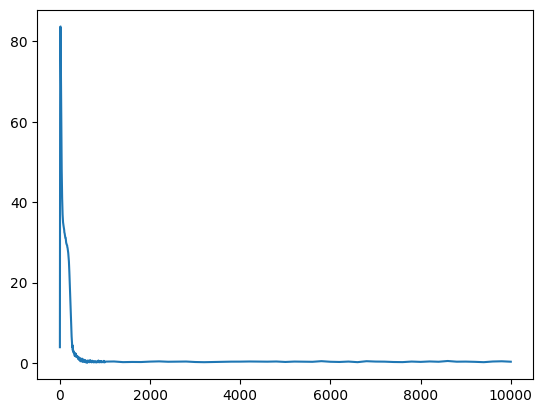

In [15]:
plt.plot(value_states_norm.keys(), value_states_norm.values(), label='value_states')

In [18]:
model.layers[1].attention.wo.weight.norm()

tensor(24.8020, device='cuda:2', grad_fn=<LinalgVectorNormBackward0>)

In [20]:
ds.cond[:, 0]

array([1.80579514e-01, 1.17721847e-05, 5.65837937e-01, 0.00000000e+00,
       0.00000000e+00, 1.92338775e-02, 2.77385871e-01, 1.27569847e-01,
       8.46670894e-01, 0.00000000e+00, 8.49360217e-01, 4.65545755e-01,
       7.44516653e-01, 1.27893593e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.16840350e-04,
       0.00000000e+00, 8.95875592e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.82448458e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.81959032e-03,
       3.53325678e-04, 3.84049158e-04, 2.52567128e-02, 1.51567999e-02,
       8.56055802e-03, 9.80832585e-03, 4.11225882e-03, 2.19601643e-05,
       0.00000000e+00, 1.15688488e-02, 5.60904646e-03, 5.66470350e-03,
       9.29341219e-03, 2.27970455e-03, 3.97853442e-03, 0.00000000e+00,
      

In [21]:
ds.cond[0, :]

array([1.80579514e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.32515813e-03, 0.00000000e+00, 5.00012500e-05,
       0.00000000e+00, 6.75016875e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.58023951e-02, 4.17260432e-02, 2.86257156e-02,
       1.89254731e-02, 9.60024001e-03, 3.01507538e-02, 2.19505488e-02,
       3.88509713e-02, 6.24015600e-02, 4.62511563e-03, 1.44503613e-02,
       2.41006025e-02, 3.49758744e-02, 2.47256181e-02, 2.76006900e-02,
       2.36505913e-02, 5.57513938e-03, 1.20503013e-02, 4.17760444e-02,
       1.03552589e-01, 5.40013500e-03, 4.47511188e-03, 6.82267057e-02,
       0.00000000e+00, 1.80754519e-02, 0.00000000e+00, 4.20010500e-03,
       2.77506938e-03, 2.80007000e-03, 1.87504688e-03, 9.50023751e-04,
       2.20005500e-03, 1.15002875e-03, 3.57508938e-03, 2.20005500e-03,
       1.50003750e-04, 4.25010625e-04, 1.00002500e-03, 2.62506563e-03,
       1.75004375e-03, 1.92504813e-03, 2.00005000e-03, 7.50018750e-05,
      

In [23]:
ds.itos

{0: '\n',
 1: ' ',
 2: '!',
 3: '$',
 4: '&',
 5: "'",
 6: ',',
 7: '-',
 8: '.',
 9: '3',
 10: ':',
 11: ';',
 12: '?',
 13: 'A',
 14: 'B',
 15: 'C',
 16: 'D',
 17: 'E',
 18: 'F',
 19: 'G',
 20: 'H',
 21: 'I',
 22: 'J',
 23: 'K',
 24: 'L',
 25: 'M',
 26: 'N',
 27: 'O',
 28: 'P',
 29: 'Q',
 30: 'R',
 31: 'S',
 32: 'T',
 33: 'U',
 34: 'V',
 35: 'W',
 36: 'X',
 37: 'Y',
 38: 'Z',
 39: 'a',
 40: 'b',
 41: 'c',
 42: 'd',
 43: 'e',
 44: 'f',
 45: 'g',
 46: 'h',
 47: 'i',
 48: 'j',
 49: 'k',
 50: 'l',
 51: 'm',
 52: 'n',
 53: 'o',
 54: 'p',
 55: 'q',
 56: 'r',
 57: 's',
 58: 't',
 59: 'u',
 60: 'v',
 61: 'w',
 62: 'x',
 63: 'y',
 64: 'z',
 65: '<s_0>',
 66: '<d>'}